## Setup and Load Data

### 1. Setup Python Environment

This cell installs the required Python packages (`rpy2`) for running R code in this notebook.

In [22]:
import sys
try:
    import rpy2
except ImportError:
    !{sys.executable} -m pip install rpy2

This cell loads the required Python packages (`rpy2`) for running R code in this notebook.

In [23]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### 2. Load Data

In [ ]:
pip install "pandas[excel]" numpy matplotlib seaborn scikit-learn openpyxl


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install statsmodels # For python linear regression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 12.8 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [26]:
data = pd.read_excel("data/personal_finance_dataset.xlsx", sheet_name = "datathon_finance")
dictionary = pd.read_excel("data/personal_finance_dataset.xlsx", sheet_name = "dictionary")

## Cleaning the Dataset

### 1. Inspecting the Dataset
We inspect the dataset using shape, head, info, and describe(). All 19 columns and 16,241 rows have non-null values, indicating there are no missing entries.

In [27]:
data.shape
data.head()
data.info()
data.describe()

data.isna().sum() # Check for missing values

<class 'pandas.DataFrame'>
RangeIndex: 16241 entries, 0 to 16240
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   PAGEMIEG  16241 non-null  int64
 1   PATTCRU   16241 non-null  int64
 2   PATTSITC  16241 non-null  int64
 3   PATTSKP   16241 non-null  int64
 4   PEDUCMIE  16241 non-null  int64
 5   PEFATINC  16241 non-null  int64
 6   PFMTYPG   16241 non-null  int64
 7   PFTENUR   16241 non-null  int64
 8   PLFFPTME  16241 non-null  int64
 9   PNBEARG   16241 non-null  int64
 10  PPVRES    16241 non-null  int64
 11  PWAPRVAL  16241 non-null  int64
 12  PWASTDEP  16241 non-null  int64
 13  PWATFS    16241 non-null  int64
 14  PWDPRMOR  16241 non-null  int64
 15  PWDSLOAN  16241 non-null  int64
 16  PWDSTCRD  16241 non-null  int64
 17  PWDSTLOC  16241 non-null  int64
 18  PWNETWPG  16241 non-null  int64
dtypes: int64(19)
memory usage: 2.4 MB


PAGEMIEG    0
PATTCRU     0
PATTSITC    0
PATTSKP     0
PEDUCMIE    0
PEFATINC    0
PFMTYPG     0
PFTENUR     0
PLFFPTME    0
PNBEARG     0
PPVRES      0
PWAPRVAL    0
PWASTDEP    0
PWATFS      0
PWDPRMOR    0
PWDSLOAN    0
PWDSTCRD    0
PWDSTLOC    0
PWNETWPG    0
dtype: int64

### 2. Filter Age Group
Keep only respondents aged 18–54 (PAGEMIEG 1–4).

In [28]:
# Remove the group ages not in 18-54
data = data[data['PAGEMIEG'].isin([1, 2, 3, 4])]

### 3. Classify Variables
We extract lists of binary, categorical, and continuous columns from the data dictionary.

In [29]:
# Find binary columns
binary_cols = dictionary[dictionary['Type'] == 'Binary']['Variable Name'].tolist()
print(binary_cols)

# Find categorial columns
categorial_cols = dictionary[dictionary['Type'] == 'Categorical']['Variable Name'].tolist()
print(categorial_cols)

# Find continuous columns
continuous_cols = dictionary[dictionary['Type'] == 'Continuous']['Variable Name'].tolist()
print(continuous_cols)

['PATTSKP']
['PAGEMIEG', 'PATTCRU', 'PATTSITC', 'PEDUCMIE', 'PFMTYPG', 'PFTENUR', 'PLFFPTME', 'PNBEARG', 'PPVRES']
['PEFATINC', 'PWAPRVAL', 'PWASTDEP', 'PWATFS', 'PWDPRMOR', 'PWDSLOAN', 'PWDSTCRD', 'PWDSTLOC', 'PWNETWPG']


### 4. Check for Unexpected Values
We check for outliers to decide what to do with those affected rows.

In [30]:
# Binary columns
for col in binary_cols:
    print(col, sorted(data[col].unique()))

PATTSKP [np.int64(1), np.int64(2)]


In [31]:
# Categorical columns
for col in categorial_cols:
    print(col, sorted(data[col].unique()))

PAGEMIEG [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
PATTCRU [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
PATTSITC [np.int64(1), np.int64(2), np.int64(3)]
PEDUCMIE [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(9)]
PFMTYPG [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(9)]
PFTENUR [np.int64(1), np.int64(2), np.int64(3)]
PLFFPTME [np.int64(1), np.int64(2), np.int64(3), np.int64(6), np.int64(9)]
PNBEARG [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(9)]
PPVRES [np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(24), np.int64(35), np.int64(46), np.int64(47), np.int64(48), np.int64(59)]


In [32]:
# Continuous columns
for col in continuous_cols:
    print(col)
    print(data[col].describe())
    print(sorted(data[col].unique())[:10], '...', sorted(data[col].unique())[-10:])
    print()

PEFATINC
count    6.349000e+03
mean     1.150532e+05
std      8.851525e+04
min     -1.682575e+06
25%      6.140000e+04
50%      1.004000e+05
75%      1.513750e+05
max      1.638300e+06
Name: PEFATINC, dtype: float64
[np.int64(-1682575), np.int64(-592550), np.int64(-277575), np.int64(-192800), np.int64(-142225), np.int64(-118650), np.int64(-87800), np.int64(-84600), np.int64(-57825), np.int64(-52875)] ... [np.int64(740475), np.int64(765200), np.int64(771500), np.int64(780425), np.int64(781650), np.int64(848550), np.int64(1168050), np.int64(1458150), np.int64(1608950), np.int64(1638300)]

PWAPRVAL
count    6.349000e+03
mean     5.185633e+05
std      6.847721e+05
min      0.000000e+00
25%      0.000000e+00
50%      3.500000e+05
75%      7.250000e+05
max      9.750000e+06
Name: PWAPRVAL, dtype: float64
[np.int64(0), np.int64(7000), np.int64(7250), np.int64(11000), np.int64(11500), np.int64(16000), np.int64(16500), np.int64(18000), np.int64(24000), np.int64(30000)] ... [np.int64(4800000), n

After inspecting each column, we see there are no unexpected values, which are given from the dictionary.

### 5. Add necessary variables to the dataset
We add or transform variables needed for analysis, such as:
- Encoding categorical and binary variables into numeric form suitable for clustering.
- Scaling continuous financial variables to ensure all features are on a comparable scale.
- Creating any derived variables that summarize or combine information, if relevant (e.g., total debt, net assets).

### 6. Saving the cleaned data

In [33]:
data.to_excel('data/cleaned_financial_data.xlsx', index=False)

## Identifying Key Predictors of Financial Stress and Stability

### Models

#### 1. Decision Tree Regressor

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [ ]:
# 1. Loading data
df = pd.read_excel('data/cleaned_financial_data.xlsx')

In [ ]:
# 2. Feature Selection & Preprocessing
# Target: PWNETWPG (Net Worth)
# Features: Income, Age, Home Value, Savings, Debt, etc.
features = [
    'PAGEMIEG', 'PEDUCMIE', 'PEFATINC', 'PFMTYPG', 'PFTENUR', 
    'PNBEARG', 'PPVRES', 'PWAPRVAL', 'PWASTDEP', 'PWATFS', 
    'PWDPRMOR', 'PWDSLOAN', 'PWDSTCRD', 'PWDSTLOC'
]

X = df[features]
y = df['PWNETWPG']

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. Define the Search Space
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['squared_error', 'friedman_mse']
}

In [ ]:
# 4. Initialize Grid Search
# We use a Regressor here because Net Worth is a dollar amount
grid_search = GridSearchCV(
    estimator = DecisionTreeRegressor(random_state = 42),
    param_grid = param_grid,
    cv = 5, 
    scoring = 'r2',  # R-squared measures how well the features explain the variance in net worth
    verbose = 1
)

In [ ]:
# 5. Fit the Model 
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'criterion': ['squared_error', 'friedman_mse'], 'max_depth': [5, 10, ...], 'min_samples_leaf': [1, 5, ...], 'min_samples_split': [2, 10, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for e

In [ ]:
# 6. Results and Evaluation
best_regressor = grid_search.best_estimator_

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation R2: {grid_search.best_score_:.4f}")

# Final Test set metrics
y_pred = best_regressor.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test Set R2 Score: {test_r2:.4f}")
print(f"Mean Absolute Error (Avg $ error): ${mae:,.2f}")


Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best Cross-Validation R2: 0.5394
Final Test Set R2 Score: 0.5625
Mean Absolute Error (Avg $ error): $523,350.57


In [ ]:
# 7. Feature Importance
# This identifies what actually drives wealth in your dataset
importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Key Drivers of Net Worth ---")
print(importances.head(5))


--- Key Drivers of Net Worth ---
     Feature  Importance
7   PWAPRVAL    0.569755
3    PFMTYPG    0.174952
8   PWASTDEP    0.069953
2   PEFATINC    0.062119
10  PWDPRMOR    0.059322


So from this, we are given the key drivers of net worth ranked highest to lowest.

#### 2. Forward Stepwise Selection

Performing forward stepwise selection to determine a good model to predict the net worth of an individual.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# 1. Load data
df = pd.read_excel("data/cleaned_financial_data.xlsx", sheet_name=0)
df = df.dropna()

In [ ]:
# 2. Log-transform the target with shift
shift = df['PWNETWPG'].min()
df['log_PWNETWPG'] = np.log(df['PWNETWPG'] - shift + 1)

In [ ]:
# 3. Separate predictors and response
X = df.drop(columns=['PWNETWPG', 'log_PWNETWPG'])
y = df['log_PWNETWPG']
n_vars = X.shape[1]

In [ ]:
# 4. 10-Fold CV setup
k = 10
kf = KFold(n_splits = k, shuffle = True, random_state = 1)

In [ ]:
# 5. Forward Selection manually
selected_features = []
remaining_features = list(X.columns)
cv_errors = []

In [62]:
for i in range(n_vars):
    best_feature = None
    best_mse = np.inf
    
    for feature in remaining_features:
        current_features = selected_features + [feature]
        fold_mses = []
        
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx][current_features], X.iloc[test_idx][current_features]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            model = LinearRegression().fit(X_train, y_train)
            pred = model.predict(X_test)
            fold_mses.append(mean_squared_error(y_test, pred))
        
        avg_mse = np.mean(fold_mses)
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_feature = feature
            
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    cv_errors.append(best_mse)
    print(f"Step {i+1}: Added {best_feature}, CV MSE = {best_mse:.4f}")

Step 1: Added PWAPRVAL, CV MSE = 0.0880
Step 2: Added PWATFS, CV MSE = 0.0798
Step 3: Added PEFATINC, CV MSE = 0.0763
Step 4: Added PFTENUR, CV MSE = 0.0740
Step 5: Added PWASTDEP, CV MSE = 0.0721
Step 6: Added PWDPRMOR, CV MSE = 0.0708
Step 7: Added PAGEMIEG, CV MSE = 0.0697
Step 8: Added PFMTYPG, CV MSE = 0.0690
Step 9: Added PWDSTCRD, CV MSE = 0.0689
Step 10: Added PWDSLOAN, CV MSE = 0.0689
Step 11: Added PNBEARG, CV MSE = 0.0688
Step 12: Added PWDSTLOC, CV MSE = 0.0688
Step 13: Added PPVRES, CV MSE = 0.0688
Step 14: Added PLFFPTME, CV MSE = 0.0688
Step 15: Added PATTSKP, CV MSE = 0.0688
Step 16: Added PEDUCMIE, CV MSE = 0.0688
Step 17: Added PATTSITC, CV MSE = 0.0688
Step 18: Added PATTCRU, CV MSE = 0.0690


In [ ]:
# 6. Optimal number of features
best_size = np.argmin(cv_errors) + 1
print(f"\nOptimal Number of Variables: {best_size}")
best_features = selected_features[:best_size]
print("Selected Features:", best_features)


Optimal Number of Variables: 15
Selected Features: ['PWAPRVAL', 'PWATFS', 'PEFATINC', 'PFTENUR', 'PWASTDEP', 'PWDPRMOR', 'PAGEMIEG', 'PFMTYPG', 'PWDSTCRD', 'PWDSLOAN', 'PNBEARG', 'PWDSTLOC', 'PPVRES', 'PLFFPTME', 'PATTSKP']


In [ ]:
# 7. Fit final model on all data with best features
X_best = sm.add_constant(X[best_features])
final_model = sm.OLS(y, X_best).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:           log_PWNETWPG   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     462.4
Date:                Sun, 01 Mar 2026   Prob (F-statistic):               0.00
Time:                        00:07:20   Log-Likelihood:                -484.28
No. Observations:                6349   AIC:                             1001.
Df Residuals:                    6333   BIC:                             1109.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6822      0.032    452.162      0.0

In [ ]:
# 8. VIF calculation
vif_data = pd.DataFrame()
vif_data["Variable"] = X_best.columns
vif_data["VIF"] = [variance_inflation_factor(X_best.values, i) for i in range(X_best.shape[1])]
print(vif_data)

    Variable        VIF
0      const  97.908873
1   PWAPRVAL   2.047324
2     PWATFS   1.226287
3   PEFATINC   1.405917
4    PFTENUR   1.436474
5   PWASTDEP   1.096661
6   PWDPRMOR   1.518428
7   PAGEMIEG   1.121316
8    PFMTYPG   1.225734
9   PWDSTCRD   1.067067
10  PWDSLOAN   1.036293
11   PNBEARG   1.153510
12  PWDSTLOC   1.070717
13    PPVRES   1.091763
14  PLFFPTME   1.070028
15   PATTSKP   1.034149


In [ ]:
# 9. Predictions and back-transform
final_pred_log = final_model.predict(X_best)
final_pred = np.exp(final_pred_log) - 1 + shift

In [ ]:
# 10. CV RMSE on all data
mse_cv = mean_squared_error(df['PWNETWPG'], final_pred)
rmse_cv = np.sqrt(mse_cv)
print("CV RMSE:", rmse_cv)

CV RMSE: 1369596.856077067


In [ ]:
# 11. Visualization
plt.figure(figsize=(12,5))

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Forward Selection CV MSE')

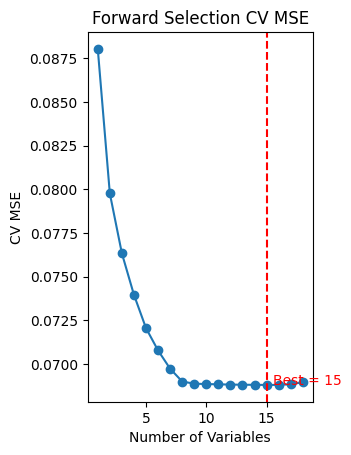

In [71]:
# CV MSE vs Number of Variables
plt.subplot(1,2,1)
plt.plot(range(1, n_vars+1), cv_errors, marker='o')
plt.axvline(best_size, color='red', linestyle='--')
plt.text(best_size + 0.5, min(cv_errors), f'Best = {best_size}', color='red')
plt.xlabel("Number of Variables")
plt.ylabel("CV MSE")
plt.title("Forward Selection CV MSE")

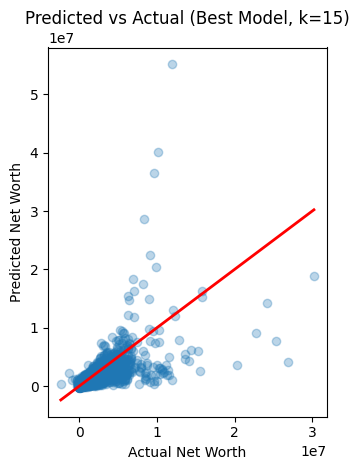

In [69]:
# Predicted vs Actual
plt.subplot(1,2,2)
plt.scatter(df['PWNETWPG'], final_pred, alpha=0.3)
plt.plot([df['PWNETWPG'].min(), df['PWNETWPG'].max()],
         [df['PWNETWPG'].min(), df['PWNETWPG'].max()],
         color='red', linewidth=2)
plt.xlabel("Actual Net Worth")
plt.ylabel("Predicted Net Worth")
plt.title(f"Predicted vs Actual (Best Model, k={best_size})")

plt.tight_layout()
plt.show()

So from this, 

## Building a segmentation model using clustering to find distinct financial personas
Doing segmentation using k-means clustering.

### 1. Preprocessing Data

In [72]:
# Selecting relevant features for clustering
features = data[['PWAPRVAL', 'PFMTYPG', 'PWASTDEP', 'PEFATINC', 'PWDPRMOR']]

In [73]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### 2. Implementing and fitting the K-means Model

In [74]:
# Fitting K-means with the optimal number of clusters
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)
labels = kmeans.labels_

In [76]:
plot_df = pd.DataFrame(scaled_features, columns=['PWAPRVAL', 'PFMTYPG', 'PWASTDEP', 'PEFATINC', 'PWDPRMOR'])
plot_df['Cluster'] = labels
print("Unique clusters found:", np.unique(labels))
print(plot_df['Cluster'].value_counts())

Unique clusters found: [0 1 2]
Cluster
0    4430
1    1256
2     663
Name: count, dtype: int64


### 3. Evaluating the K-means Model

In [77]:
score = silhouette_score(scaled_features, kmeans.labels_)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.4452551036475968


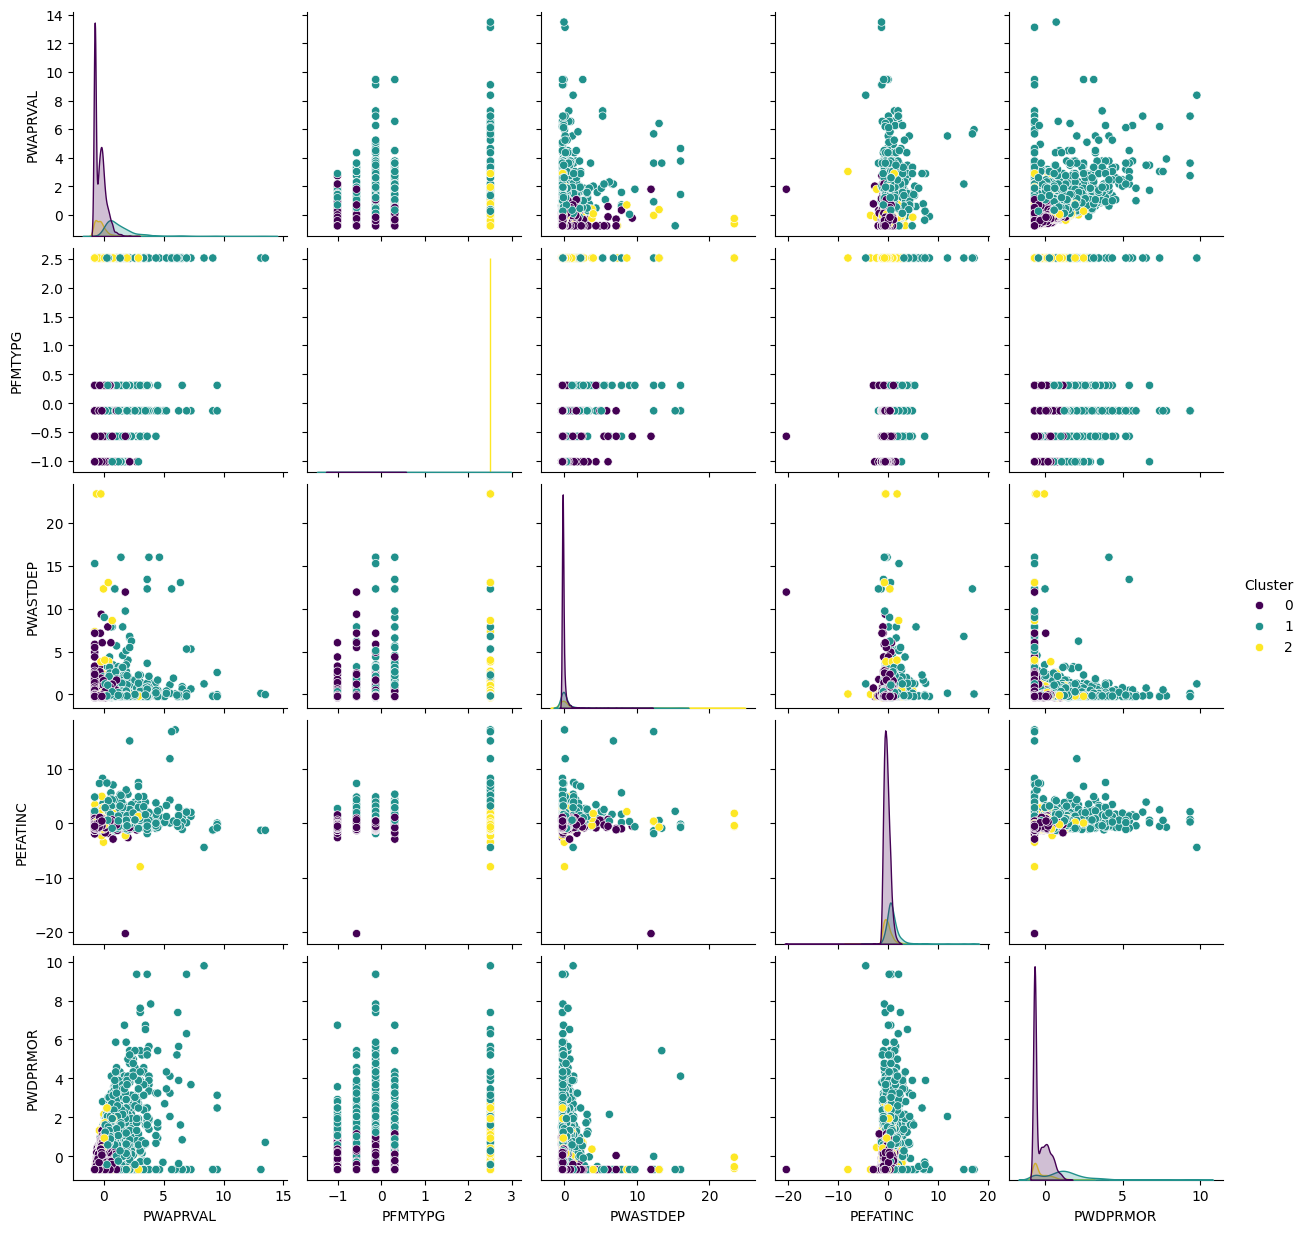

In [80]:
top_features = ['PWAPRVAL', 'PFMTYPG', 'PWASTDEP', 'PEFATINC', 'PWDPRMOR']
sns.pairplot(
    plot_df,
    vars=top_features,
    hue='Cluster',
    palette='viridis',
    diag_kind='kde'   # optional: shows density on diagonal
)
plt.show()

### 4. Analyzing Segments

In [81]:
segment_analysis = plot_df.groupby('Cluster').mean()
print(segment_analysis)
print(kmeans.cluster_centers_)

         PWAPRVAL   PFMTYPG  PWASTDEP  PEFATINC  PWDPRMOR
Cluster                                                  
0       -0.335694 -0.384356 -0.095371 -0.236911 -0.318719
1        1.319013  0.029503  0.274815  0.889978  1.245275
2       -0.255744  2.512278  0.116634 -0.103010 -0.229475
[[-0.33539787 -0.38414213 -0.09526755 -0.23669357 -0.3182914 ]
 [ 1.32060717  0.02940778  0.27503805  0.8910062   1.24625932]
 [-0.25574361  2.51227839  0.1166336  -0.10301038 -0.22947464]]
